In [1]:
import numpy as np
import pandas as pd
import re
import time
from pathlib import Path

from transformers import OpenAIGPTTokenizer, OpenAIGPTModel

import os
import openai
from openai import OpenAI

import matplotlib as plt
import seaborn as sns
import tiktoken

pd.set_option('display.max_colwidth', None)

/var/folders/cn/413wvqnx6bxcv8pkd_b2v_ww0000gn/T/ipykernel_2119/650343124.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/dhwaniserai/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
with open('api-key-jan-2024') as f:
    OPENAI_API_KEY = f.read().strip()
    
client = OpenAI(api_key=OPENAI_API_KEY, base_url='https://api.together.xyz')

In [4]:
# download data from: https://people.eecs.berkeley.edu/~hendrycks/data.tar

abstract_algebra_data_path = Path('data/abstract_algebra_val.csv')
college_mathematics_data_path = Path('data/college_mathematics_val.csv')
electrical_engineering_data_path = Path('data/electrical_engineering_val.csv')
elementary_math_data_path = Path('data/elementary_mathematics_val.csv')
high_school_mathematics_data_path = Path('data/high_school_mathematics_val.csv')
high_school_statistics_data_path = Path('data/high_school_statistics_val.csv')
machine_learning_data_path = Path('data/machine_learning_val.csv')
moral_disputes_data_path = Path('data/moral_disputes_val.csv')
moral_scenarios_data_path = Path('data/moral_scenarios_val.csv')

In [5]:
df_algebra = pd.read_csv(abstract_algebra_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_college_math = pd.read_csv(college_mathematics_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_school_math = pd.read_csv(high_school_mathematics_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_elementary_math = pd.read_csv(elementary_math_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_electrical = pd.read_csv(electrical_engineering_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_school_stat = pd.read_csv(high_school_statistics_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_ml = pd.read_csv(machine_learning_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_moral_scene = pd.read_csv(moral_scenarios_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])
df_moral_disp = pd.read_csv(moral_disputes_data_path, names=['text', 'A', 'B', 'C', 'D', 'answer'])

In [6]:
dataset_sizes = {
    'Abstract Algebra': len(df_algebra),
    'College math': len(df_college_math),
    'High School math': len(df_school_math),
    'Elementary math': len(df_elementary_math),
    'Electrical Engineering': len(df_electrical),
    'High school statistics': len(df_school_stat),
    'Machine Learning': len(df_ml),
    'Moral scenarios': len(df_moral_scene),
    'Moral disputes': len(df_moral_disp)
}
for key, value in dataset_sizes.items():
    print(f"Length {key} df: {value}")

Length Abstract Algebra df: 11
Length College math df: 11
Length High School math df: 29
Length Elementary math df: 41
Length Electrical Engineering df: 16
Length High school statistics df: 23
Length Machine Learning df: 11
Length Moral scenarios df: 100
Length Moral disputes df: 38


In [10]:
df_algebra["subject"] = "Abstract Algebra"
df_college_math["subject"] = "College math"
df_school_math["subject"] = "High School math"
df_elementary_math["subject"] = "Elementary math"
df_electrical["subject"] = "Electrical Engineering"
df_school_stat["subject"] = "High school statistics"
df_ml["subject"] = "Machine Learning"
df_moral_scene["subject"] = "Moral scenarios"
df_moral_disp["subject"] = "Moral disputes"

df = pd.concat([df_algebra, df_college_math, df_school_math, df_elementary_math, \
                df_electrical, df_school_stat, df_ml, df_moral_scene, df_moral_disp])
df.head()

,text,A,B,C,D,answer,subject
0,The cyclic subgroup of Z_24 generated by 18 has order,4,8,12,6,A,Abstract Algebra
1,Find the order of the factor group Z_6/<3>.,2,3,6,12,B,Abstract Algebra
2,Statement 1 | A permutation that is a product of m even permutations and n odd permutations is an even permutation if and only if n is even. Statement 2 | Every group is isomorphic to a group of permutations.,"True, True","False, False","True, False","False, True",A,Abstract Algebra
3,Find the order of the factor group (Z_4 x Z_12)/(<2> x <2>),2,3,4,12,C,Abstract Algebra
4,Find the maximum possible order for some element of Z_4 x Z_6.,4,6,12,24,C,Abstract Algebra


In [19]:
df["subject"].value_counts()

subject
Moral scenarios           100
Elementary math            41
Moral disputes             38
High School math           29
High school statistics     23
Electrical Engineering     16
Abstract Algebra           11
College math               11
Machine Learning           11
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='subject'>

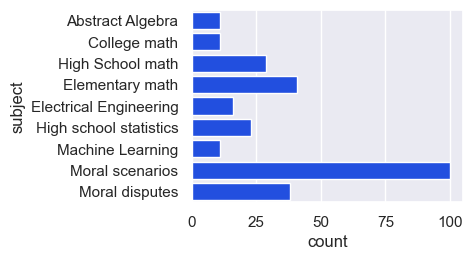

In [25]:
sns.countplot(y="subject", data=df)

In [ ]:
dataset_avg_text_length = {
    'Abstract Algebra': round(df_algebra["text"].apply(len).mean()),
    'College math': round(df_college_math["text"].apply(len).mean()),
    'High School math': round(df_school_math["text"].apply(len).mean()),
    'Elementary math': round(df_elementary_math["text"].apply(len).mean()),
    'Electrical Engineering': round(df_electrical["text"].apply(len).mean()),
    'High school statistics': round(df_school_stat["text"].apply(len).mean()),
    'Machine Learning': round(df_ml["text"].apply(len).mean()),
    'Moral scenarios': round(df_moral_scene["text"].apply(len).mean()),
    'Moral disputes': round(df_moral_disp["text"].apply(len).mean())
}
for key, value in dataset_avg_text_length.items():
    print(f"Average text length {key} df: {value}")
all_dfs[1] = dataset_avg_text_length.values()

In [ ]:
sns.set_theme(rc={'figure.figsize':(3.5,2.5)},palette="bright")
fig = sns.barplot(data=all_dfs, y=all_dfs.index, x=all_dfs[1])
fig.set(xlabel='Average length of question', ylabel='Subjects')